# Model exploration

Predict the video annotations using LLMs and vision models

## Set up the environment

In [1]:
import os
import getpass
from pathlib import Path
from tqdm import tqdm

In [29]:
top_dir = '/content'
interim_dir = f'{top_dir}/data/interim'
raw_dir = f'{top_dir}/data/raw'
remote_path = '/projects/SI_fmri/SIfMRI_modeling/data'

out_path = f'{interim_dir}/CaptionData'
figures_dir = f'{top_dir}/reports/figures/CaptionData'
Path(out_path).mkdir(exist_ok=True, parents=True)
Path(raw_dir).mkdir(exist_ok=True, parents=True)
Path(figures_dir).mkdir(exist_ok=True, parents=True)

In [3]:
def is_running_in_colab():
    try:
        import google.colab
        return True
    except ImportError:
        return False

In [5]:
if is_running_in_colab():
    !pip install dropbox
    import dropbox
    personal_access_token = getpass.getpass('Enter your Personal Access Token: ')
    dbx = dropbox.Dropbox(personal_access_token)

    if True:
        Path(f'{interim_dir}/CaptionData/').mkdir(exist_ok=True, parents=True)
        list_folder_result = dbx.files_list_folder(path=f'{remote_path}/interim/CaptionData')
        for entry in tqdm(list_folder_result.entries, total=len(list_folder_result.entries)):
            file = entry.path_lower.split('/')[-1]
            dbx.files_download_to_file(f'{interim_dir}/CaptionData/{file}', entry.path_lower)

    if False:
        Path(f'{raw_dir}/images/').mkdir(exist_ok=True, parents=True)
        list_folder_result = dbx.files_list_folder(path=f'{remote_path}/raw/images')
        for entry in tqdm(list_folder_result.entries, total=len(list_folder_result.entries)):
            file = entry.path_lower.split('/')[-1]
            dbx.files_download_to_file(f'{raw_dir}/images/{file}', entry.path_lower)

    if True:
        Path(f'{raw_dir}/betas/').mkdir(exist_ok=True, parents=True)
        list_folder_result = dbx.files_list_folder(path=f'{remote_path}/raw/betas')
        for entry in tqdm(list_folder_result.entries, total=len(list_folder_result.entries)):
            file = entry.path_lower.split('/')[-1]
            dbx.files_download_to_file(f'{raw_dir}/betas/{file}', entry.path_lower)

    if True:
        Path(f'{raw_dir}/reliable_voxels/').mkdir(exist_ok=True, parents=True)
        list_folder_result = dbx.files_list_folder(path=f'{remote_path}/raw/reliable_voxels')
        for entry in tqdm(list_folder_result.entries, total=len(list_folder_result.entries)):
            file = entry.path_lower.split('/')[-1]
            dbx.files_download_to_file(f'{raw_dir}/reliable_voxels/{file}', entry.path_lower)

Enter your Personal Access Token: ··········


100%|██████████| 4/4 [00:02<00:00,  1.88it/s]


In [6]:
target_dir = '/content/DeepJuiceDev'
if is_running_in_colab():
  if not os.path.exists(target_dir):
    personal_access_token = getpass.getpass('Enter your Personal Access Token: ')
    git_location = 'github.com/ColinConwell/DeepJuiceDev.git'
    git_url = f"https://{personal_access_token}@{git_location}"
    !git clone $git_url # Execute the git clone command to download the repo
  if not os.getcwd() == target_dir:
    os.chdir(target_dir) # change directory into the DeepJuiceDev repo for use

Enter your Personal Access Token: ··········
Cloning into 'DeepJuiceDev'...
remote: Enumerating objects: 3781, done.
remote: Counting objects: 100% (118/118), done.
remote: Compressing objects: 100% (84/84), done.
remote: Total 3781 (delta 44), reused 81 (delta 28), pack-reused 3663
Receiving objects: 100% (3781/3781), 97.49 MiB | 17.04 MiB/s, done.
Resolving deltas: 100% (1532/1532), done.
Updating files: 100% (3468/3468), done.


In [7]:
import re
from glob import glob

import pandas as pd
import numpy as np
import torch

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import KFold
from sklearn.linear_model import RidgeCV
from sklearn.metrics import make_scorer

In [8]:
if is_running_in_colab():
    !pip install -q mtalg torchmetrics torchinfo git+https://github.com/johnmarktaylor91/torchlens
    !pip install timm ftfy sentence_transformers
from sentence_transformers import SentenceTransformer


  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 805.2/805.2 kB 6.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 11.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 26.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.1/53.1 kB 7.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.0/86.0 kB 12.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.0/302.0 kB 36.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 90.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.9/7.9 MB 113.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 86.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 90.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 36.7 MB/s eta 0:00:00
  Created wheel for sentence_trans

In [9]:
from deepjuice.extraction import *
from glob import glob
from deepjuice import * #importing all deepjuice modules

Loading all deepjuice modules...


In [10]:
from deepjuice.systemops.sysreport import SystemStats
SystemStats() # class also contains cpu_info and gpu_info

Available RAM: 11.338 GB 
Available Cores: 2 
Available GPU(s): 1: 15.770 GB

In [27]:
import nibabel as nib
import pandas as pd
import numpy as np
import json

rois = ['reliable']
subjects = range(1,5)
all_data = []
all_betas = []

for sub in subjects:
  sub_fill = str(sub).zfill(2)
  sub = str(sub)
  # Beta files
  betas_file = f"/content/data/raw/betas/sub-{sub_fill}_space-t1w_desc-train-fracridge_data.nii.gz"
  betas_arr = nib.load(betas_file).get_fdata()

  # metadata
  first_betas = betas_arr[:,:,:,0]
  first_betas = first_betas.astype(str)

  # response data
  if sub == '1':
    all_mask = np.ones([71, 90, 68]).astype(bool)
  elif sub == '2':
    all_mask = np.ones([72, 88, 72]).astype(bool)
  elif sub == '3':
    all_mask = np.ones([71, 93, 72]).astype(bool)
  elif sub == '4':
    all_mask = np.ones([73, 94, 72]).astype(bool)
  all_betas.append(betas_arr[all_mask,:])

  for roi in rois:
    subd = {}
    file = f"/content/data/raw/reliable_voxels/sub-{sub_fill}_space-t1w_desc-test-fracridge_reliability-mask.nii.gz"
    roi_mask = nib.load(file).get_fdata().astype(bool)
    first_betas[roi_mask] = roi

  if sub == '1':
    all_mask = np.ones([71, 90, 68]).astype(bool)
  elif sub == '2':
    all_mask = np.ones([72, 88, 72]).astype(bool)
  elif sub == '3':
    all_mask = np.ones([71, 93, 72]).astype(bool)
  elif sub == '4':
    all_mask = np.ones([73, 94, 72]).astype(bool)
  sub_data = [(ind, roi, sub) for (ind, roi) in enumerate(first_betas[all_mask])]
  all_data.append(sub_data)

# metadata
df_metadata1 = pd.DataFrame(all_data[0], columns =['voxel_id', 'roi_name', 'subj_id'])
df_metadata2 = pd.DataFrame(all_data[1], columns =['voxel_id', 'roi_name', 'subj_id'])
df_metadata3 = pd.DataFrame(all_data[2], columns =['voxel_id', 'roi_name', 'subj_id'])
df_metadata4 = pd.DataFrame(all_data[3], columns =['voxel_id', 'roi_name', 'subj_id'])
df_metadata = pd.concat([df_metadata1, df_metadata2, df_metadata3, df_metadata4], ignore_index=True)
metadata = df_metadata[df_metadata.roi_name.isin(rois)]
metadata.reset_index(drop=True, inplace=True)

# response data
voxels1 = metadata.loc[metadata['subj_id']=='1']['voxel_id'].to_list()
voxels2 = metadata.loc[metadata['subj_id']=='2']['voxel_id'].to_list()
voxels3 = metadata.loc[metadata['subj_id']=='3']['voxel_id'].to_list()
voxels4 = metadata.loc[metadata['subj_id']=='4']['voxel_id'].to_list()

response_data_1 = pd.DataFrame(all_betas[0][voxels1,:]).fillna(0)
response_data_2 = pd.DataFrame(all_betas[1][voxels2,:]).fillna(0)
response_data_3 = pd.DataFrame(all_betas[2][voxels3,:]).fillna(0)
response_data_4 = pd.DataFrame(all_betas[3][voxels4,:]).fillna(0)
response_data = pd.concat([response_data_1, response_data_2, response_data_3, response_data_4], ignore_index=True)

## Load the data

In [30]:
annotations = pd.read_csv(f'{interim_dir}/CaptionData/stimulus_data_train.csv')
annotations.head()

,video_name,rating-indoor,rating-expanse,rating-object,rating-agent_distance,rating-facingness,rating-joint_action,rating-communication,rating-valence,rating-arousal,captions
0,-YwZOeyAQC8_15.mp4,1,0.225,0.895833,0.000000,0.045455,0.700,0.550000,0.650000,0.340909,['A man playing on the wii which is making the...
1,1AIVH5cEWrI_35.mp4,1,0.250,0.104167,0.075000,1.000000,0.825,0.900000,0.675000,0.340909,['Two young women are facing one another and s...
2,2-8-0-2-5-4-8-8-5028025488_7.mp4,1,0.275,1.000000,0.045455,0.050000,0.575,0.500000,0.675000,0.075000,['A little girl around 6 years old is paging t...
3,7-5-1-0-3-6-9-8-3775103698_9.mp4,1,0.275,0.925000,0.275000,0.636364,0.750,0.825000,0.722222,0.125000,"['two people discuss plans for a playground', ..."
4,8-6-0-3-9-6-6-0-19586039660_4.mp4,1,0.325,0.950000,0.227273,0.150000,0.425,0.727273,0.650000,0.350000,"['Two kids playing with a toy dog.', 'Kids pla..."


In [31]:
# Add the image path
annotations['image_path'] = 'data/raw/images/' + annotations.video_name.str.replace('.mp4', '.png')
annotations['image_path'] = annotations.image_path.str.lower()

<ipython-input-31-ed1e9a60ca6c>:2: FutureWarning: The default value of regex will change from True to False in a future version.
  annotations['image_path'] = 'data/raw/images/' + annotations.video_name.str.replace('.mp4', '.png')


In [32]:
# Get the ratings for prediction
rating_cols = ['video_name',] + [col for col in annotations.columns if 'rating' in col]
ratings = annotations[rating_cols].set_index('video_name').transpose()

I am not sure why a few videos only have 4 captions. I need to follow up how I am combining the data in the df to save because it shouldn't be possible for only a few videos to be missing captions

In [34]:
# Get the captions
captions = [eval(caption_list)[:5] for caption_list
            in annotations.captions]

In [35]:
noise_ceiling = pd.read_csv(f'{interim_dir}/CaptionData/train_rating_noise_ceiling.csv')
noise_ceiling.replace({'rating-object': 'rating-transitivity'}, inplace=True)
noise_ceiling.set_index('question_name', inplace=True)
noise_ceiling

,nc
question_name,
rating-agent_distance,0.721796
rating-arousal,0.794244
rating-communication,0.767897
rating-expanse,0.763655
rating-facingness,0.960227
rating-joint_action,0.900336
rating-transitivity,0.931695
rating-valence,0.763245


## LLMs

In [37]:
def get_llm_benchmarking_results(response_data, feature_maps,
                             layer_index_offset = 0,
                             score_types = ['pearsonr'],
                             feature_map_stats = None,
                             train_test_splits=10,
                             alpha_values = np.logspace(-1,5,7).tolist(),
                             regression_means = True, device='cuda:0'):

    method_info = {'regression': {'encoding_model': 'ridge'}}

    scoresheet_lists = []

    y = (convert_to_tensor(response_data.to_numpy())
         .to(dtype=torch.float32, device=device))
    y = {'train': y[:,::2].T, 'test': y[:,1::2].T}

    neuroid_ids = ratings.index.to_list()

    regression = TorchRidgeGCV(alphas = alpha_values, device = device, scale_X = True)
    score_funcs = {score_type: get_scorer(score_type) for score_type in score_types}

    layer_index = 0

    for feature_map_uid, feature_map in tqdm(feature_maps.items(), desc = 'Brain Mapping (Layer)'):
        layer_index += 1 # add to total feature_maps_computed

        feature_map_info = {'model_layer': feature_map_uid,
                            'model_layer_index': layer_index + layer_index_offset}

        X = feature_map.squeeze().to(torch.float32).to(device)
        X = {'train': X[0::2,], 'test': X[1::2,:]}

        regression.fit(X['train'], y['train'])
        y_pred = {'train': regression.cv_y_pred_, 'test': regression.predict(X['test'])}

        for score_set in ['train','test']:
            for score_type in ['pearsonr']:
                scores = score_funcs[score_type](y[score_set], y_pred[score_set]).cpu()
                scores = [x.item() for x in scores] # tensor to list

                for index, neuroid_id in enumerate(neuroid_ids):
                    scoresheet = {**feature_map_info,
                                'neuroid_id': neuroid_id,
                                'score': scores[index],
                                'score_set': score_set,
                                **method_info['regression']}

                    scoresheet_lists.append(scoresheet)

    return pd.DataFrame(scoresheet_lists)

In [39]:
alpha_values = tuple(np.logspace(-1,5,7))
splitter = KFold(n_splits=10, shuffle=True, random_state=0)

model_ids = ['sentence-transformers/all-MiniLM-L6-v2', 'sentence-transformers/average_word_embeddings_glove.6B.300d']
model_names = ['mini_bert', 'glove']
for model_name, model_id in zip(model_names, model_ids):
    model = SentenceTransformer(model_id)

    text_features = []
    for cap in captions:
        embedding = model.encode(cap, normalize_embeddings=False)
        text_features.append(embedding.mean(axis=0))
    feature_maps = get_feature_map_srps({'Output': np.array(text_features)}, device='cuda') # reduce feature maps

    results = get_llm_benchmarking_results(response_data, feature_maps)
    results.to_csv(f'/content/data/interim/annotation-{model_name}_all_layers.csv', index=False)

    test_results = results[results.score_set == 'test']
    test_results.to_csv(f'/content/data/interim/annotation-{model_name}.csv', index=False)

SR Projection (Layer):   0%|          | 0/1 [00:00<?, ?it/s]

Brain Mapping (Layer):   0%|          | 0/1 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torchmetrics/utilities/prints.py:43: UserWarning: The variance of predictions or target is close to zero. This can cause instability in Pearson correlationcoefficient, leading to wrong results. Consider re-scaling the input if possible or computing using alarger dtype (currently using torch.float32).
  warnings.warn(*args, **kwargs)  # noqa: B028


SR Projection (Layer):   0%|          | 0/1 [00:00<?, ?it/s]

Brain Mapping (Layer):   0%|          | 0/1 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torchmetrics/utilities/prints.py:43: UserWarning: The variance of predictions or target is close to zero. This can cause instability in Pearson correlationcoefficient, leading to wrong results. Consider re-scaling the input if possible or computing using alarger dtype (currently using torch.float32).
  warnings.warn(*args, **kwargs)  # noqa: B028


## Vision models

In [ ]:
# from sklearn.model_selection import ShuffleSplit

def get_vision_benchmarking_results(ratings, feature_map_loader,
                             layer_index_offset = 0,
                             score_types = ['pearsonr'],
                             feature_map_stats = None,
                             train_test_splits=10,
                             alpha_values = np.logspace(-1,5,7).tolist(),
                             regression_means = True, device='cuda:0'):

    method_info = {'regression': {'encoding_model': 'ridge'}}

    scoresheet_lists = []

    y = convert_to_tensor(ratings.to_numpy(), dtype=torch.float32).to(device)
    y = {'train': y[:,::2].T, 'test': y[:,1::2].T}

    neuroid_ids = ratings.index.to_list()

    regression = TorchRidgeGCV(alphas = alpha_values, device = device, scale_X = True)
    score_funcs = {score_type: get_scorer(score_type) for score_type in score_types}

    layer_index = 0
    for feature_maps in feature_map_loader:

        feature_maps = get_feature_map_srps(feature_maps, device=device) # reduce feature maps

        for feature_map_uid, feature_map in tqdm(feature_maps.items(), desc = 'Brain Mapping (Layer)'):
            layer_index += 1 # add to total feature_maps_computed

            feature_map_info = {'model_layer': feature_map_uid,
                                'model_layer_index': layer_index + layer_index_offset}

            X = feature_map.squeeze().to(torch.float32).to(device)
            X = {'train': X[0::2,], 'test': X[1::2,:]}

            regression.fit(X['train'], y['train'])
            y_pred = {'train': regression.cv_y_pred_, 'test': regression.predict(X['test'])}

            for score_set in ['train','test']:
                for score_type in ['pearsonr']:
                    scores = score_funcs[score_type](y[score_set], y_pred[score_set]).cpu()
                    scores = [x.item() for x in scores] # tensor to list

                    for index, neuroid_id in enumerate(neuroid_ids):
                        scoresheet = {**feature_map_info,
                                    'neuroid_id': neuroid_id,
                                    'score': scores[index],
                                    'score_set': score_set,
                                    **method_info['regression']}

                        scoresheet_lists.append(scoresheet)

    return pd.DataFrame(scoresheet_lists)

In [ ]:
def best_model_layer_per_neuroid(df):
    # Filter the DataFrame to keep only training set results
    train_df = df[df['score_set'] == 'train']

    # Group by neuroid_id and model_layer, then find the maximum score for each
    max_scores = train_df.groupby(['neuroid_id', 'model_layer'])['score'].max().reset_index()

    # Find the model_layer with the maximum score within each neuroid_id group
    idx = max_scores.groupby(['neuroid_id'])['score'].idxmax()
    best_models_per_neuroid = max_scores.loc[idx]

    # Collect test scores corresponding to the best model_layer for each neuroid_id
    test_results = []
    for _, row in best_models_per_neuroid.iterrows():
        test_score_df = df[(df['score_set'] == 'test') & (df['neuroid_id'] == row['neuroid_id']) & (df['model_layer'] == row['model_layer'])]
        test_results.append(test_score_df)

    test_results_df = pd.concat(test_results).reset_index(drop=True)

    return best_models_per_neuroid, test_results_df

In [ ]:
from timm.models.registry import register_model
dataloader = get_image_loader(annotations.image_path, preprocess)

In [ ]:
model_names = ['ViT-S-SLIP', 'ViT-S-SimCLR', 'ViT-S-CLIP', 'resnet50']
model_uids = ['slip_vit_s_yfcc15m', 'slip_vit_s_simclr_yfcc15m', 'slip_vit_s_clip_yfcc15m', 'torchvision_resnet50_imagenet1k_v1']
for model_name, model_uid in zip(model_names, model_uids):
    model, preprocess = get_deepjuice_model(model_uid)
    feature_map_loader = FeatureMapLoader(model, dataloader, max_memory_load='24GB',
                                        flatten=True, progress=True)

    results = get_vision_benchmarking_results(ratings, feature_map_loader)
    results.to_csv(f'data/interim/annotation-{model_name}_all_layers.csv', index=False)

    best_models_per_neuroid, _ = best_model_layer_per_neuroid(results)
    best_models_per_neuroid.to_csv(f'data/interim/annotation-{model_name}.csv', index=False)

Downloading: "https://dl.fbaipublicfiles.com/slip/slip_small_25ep.pt" to /root/.cache/torch/hub/checkpoints/slip_small_25ep.pt
100%|██████████| 1.17G/1.17G [01:11<00:00, 17.6MB/s]


Feature Map Loader:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction (Batch):   0%|          | 0/4 [00:00<?, ?it/s]

SR Projection (Layer):   0%|          | 0/125 [00:00<?, ?it/s]

Brain Mapping (Layer):   0%|          | 0/125 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torchmetrics/utilities/prints.py:43: UserWarning: The variance of predictions or target is close to zero. This can cause instability in Pearson correlationcoefficient, leading to wrong results. Consider re-scaling the input if possible or computing using alarger dtype (currently using torch.float32).
  warnings.warn(*args, **kwargs)  # noqa: B028
Downloading: "https://dl.fbaipublicfiles.com/slip/simclr_small_25ep.pt" to /root/.cache/torch/hub/checkpoints/simclr_small_25ep.pt
100%|██████████| 470M/470M [00:27<00:00, 17.7MB/s]


Feature Map Loader:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction (Batch):   0%|          | 0/4 [00:00<?, ?it/s]

SR Projection (Layer):   0%|          | 0/125 [00:00<?, ?it/s]

Brain Mapping (Layer):   0%|          | 0/125 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torchmetrics/utilities/prints.py:43: UserWarning: The variance of predictions or target is close to zero. This can cause instability in Pearson correlationcoefficient, leading to wrong results. Consider re-scaling the input if possible or computing using alarger dtype (currently using torch.float32).
  warnings.warn(*args, **kwargs)  # noqa: B028


Feature Map Loader:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction (Batch):   0%|          | 0/4 [00:00<?, ?it/s]

SR Projection (Layer):   0%|          | 0/125 [00:00<?, ?it/s]

Brain Mapping (Layer):   0%|          | 0/125 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torchmetrics/utilities/prints.py:43: UserWarning: The variance of predictions or target is close to zero. This can cause instability in Pearson correlationcoefficient, leading to wrong results. Consider re-scaling the input if possible or computing using alarger dtype (currently using torch.float32).
  warnings.warn(*args, **kwargs)  # noqa: B028


Feature Map Loader:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction (Batch):   0%|          | 0/4 [00:00<?, ?it/s]

SR Projection (Layer):   0%|          | 0/158 [00:00<?, ?it/s]

Brain Mapping (Layer):   0%|          | 0/158 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torchmetrics/utilities/prints.py:43: UserWarning: The variance of predictions or target is close to zero. This can cause instability in Pearson correlationcoefficient, leading to wrong results. Consider re-scaling the input if possible or computing using alarger dtype (currently using torch.float32).
  warnings.warn(*args, **kwargs)  # noqa: B028


## Plotting

In [ ]:
model_names = ['ViT-S-SLIP', 'ViT-S-SimCLR', 'ViT-S-CLIP', 'resnet50', 'mini_bert', 'glove']
model_classes = ['vision', 'vision', 'vision', 'vision', 'language', 'language']
model_perfs = []
for model_name, model_class in zip(model_names, model_classes):
    df = pd.read_csv(f'data/interim/annotation-{model_name}.csv')
    df['model_name'] = model_name
    df['model_class'] = model_class
    model_perfs.append(df)
model_perfs = pd.concat(model_perfs)

In [ ]:
categories = ['rating-indoor', 'rating-expanse', 'rating-transitivity',
              'rating-agent_distance', 'rating-facingness', 'rating-joint_action',
              'rating-communication', 'rating-valence', 'rating-arousal']
model_perfs['neuroid_id'] = pd.Categorical(model_perfs.neuroid_id,
                                           categories=categories, ordered=True)

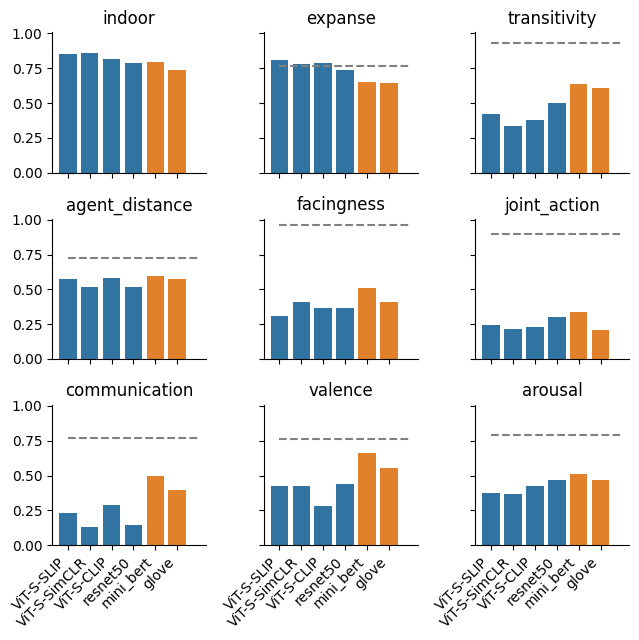

In [ ]:
_, axes = plt.subplots(3, 3, figsize=(6.5, 6.5), sharex=True, sharey=True)
axes = axes.flatten()
for ax, (rating, rating_perf) in zip(axes, model_perfs.groupby('neuroid_id')):
    sns.barplot(x='model_name', y='score', hue='model_class',
                data=rating_perf, ax=ax, dodge=False)
    ax.set_xticks(range(len(rating_perf.model_name.unique())))
    ax.set_xticklabels(rating_perf.model_name.unique(),
                    rotation=45, ha='right')
    ax.set_title(rating.replace('rating-', ''))
    ax.get_legend().remove()
    ax.set_xlabel('')
    ax.set_ylabel('')
    ax.spines[['right', 'top']].set_visible(False)

    if rating != 'rating-indoor':
        ax.hlines(noise_ceiling.loc[rating, 'nc'],
                xmin=0, xmax=len(model_names),
                linestyles='dashed', colors='gray')
plt.tight_layout()
plt.savefig('data/interim/performance.pdf')